In [143]:
# Data Import and Examination

# Training data

import pandas as pd
import numpy as np

folderpath='./human-protein-atlas-image-classification/'
train_data=pd.read_csv(folderpath+'samples/random_trainset.csv')
train_data.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,cd564e5a-bbbf-11e8-b2bb-ac1f6b6435d0,18 0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,e44a8b3a-bba6-11e8-b2ba-ac1f6b6435d0,25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,6df4016a-bbaf-11e8-b2ba-ac1f6b6435d0,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,a1846ac8-bbab-11e8-b2ba-ac1f6b6435d0,2 0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5e3212f6-bbc0-11e8-b2bb-ac1f6b6435d0,7 0 21,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [144]:
print(train_data.shape)

(2156, 30)


In [3]:
train_class_cnt=pd.DataFrame(train_data.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)).reset_index()
train_class_cnt.columns=['Class','Counts']
total_cnt=train_class_cnt['Counts'].sum()
train_class_cnt.loc[:,'Prct']=train_class_cnt['Counts']/total_cnt
threshold=train_class_cnt['Prct']
#train_class_cnt.head()
threshold.head()

0    0.247112
1    0.155255
2    0.076360
3    0.075232
4    0.056354
Name: Prct, dtype: float64

In [145]:
# Validation data
val_data=pd.read_csv(folderpath+'samples/random_testset.csv')
val_data.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,20d82004-bba1-11e8-b2b9-ac1f6b6435d0,25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0c3c58a6-bbc2-11e8-b2bb-ac1f6b6435d0,25 6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,76fe71dc-bbbe-11e8-b2ba-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bcfbade4-bbb9-11e8-b2ba-ac1f6b6435d0,5 0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,b5366d20-bbc7-11e8-b2bc-ac1f6b6435d0,7,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [146]:
print(val_data.shape)

(1081, 30)


In [147]:
np.random.seed(42)

In [148]:
import os
import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader,Subset
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score


In [149]:
class ImgDataset(Dataset):

    def __init__(self,frames, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frames = frames
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.frames.iloc[idx, 0]+'.png')
        #image = open_rgby(img_name)
        #image = load_image(self.frames.iloc[idx, 0],self.root_dir)
        img = Image.open(img_name)
        label=  torch.tensor(self.frames.iloc[idx, 2:].tolist(), dtype=torch.float32)

        if self.transform:
            #temp_img = Image.open(sample['image'])
            img = self.transform(img)
            img /= 255 
            
        sample = {'image': img, 'label': label}
        return sample

In [150]:
# Transform images          
transformer = transforms.Compose([
                                  transforms.Resize(128),
                                  #transforms.CenterCrop(128),
                                  #transforms.RandomHorizontalFlip(),
                                  #transforms.ColorJitter(brightness=0.1,contrast=0.1, hue=0.1, saturation=0.1),
                                  #transforms.RandomRotation(30),
                                  transforms.ToTensor()])
                                # transforms.Normalize(means,stds])

10
torch.Size([4, 256, 256])
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0.]


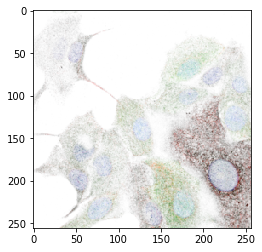

In [68]:
# Testing image import
train_df=train_data.iloc[0:10]
train_df.head()
train_dataset = ImgDataset(frames=train_df,
                           root_dir=folderpath+'updated_train/', transform=transformer)

print(len(train_dataset))

# Check image and labels
## check the images
print(torchvision.utils.make_grid(train_dataset[1]['image']).shape)
plt.imshow(torchvision.utils.make_grid(train_dataset[1]['image']*255).permute(1, 2, 0))
## check the labels related to the given image
print(train_dataset[1]['label'].numpy())


In [151]:
# Create Dataset and load data
#train_data=train_data.iloc[0:64]
#val_data=val_data.iloc[0:16] 

train_dataset = ImgDataset(frames=train_data,
                           root_dir=folderpath+'updated_train/', transform=transformer)
val_dataset = ImgDataset(frames=val_data,
                           root_dir=folderpath+'updated_train/', transform=transformer)
print(len(train_dataset))
print(len(val_dataset))

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,num_workers=0)
print(len(train_loader.dataset))
print(len(validation_loader.dataset))

2156
1081
2156
1081


In [11]:
# Testing    
dataiter=next(iter(train_loader))
x, target = dataiter['image'], dataiter['label'].float()
print(x.size(1), target.size(1))
            
#print(len(train_loader.dataset))

4 28


In [152]:
# Create CNN Model
class MultiClassifier(nn.Module):

    def __init__(self,nclasses=28):
        #self.nclasses=3 # This needs to be changed when using different number of classes for developing model
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5, stride=1, padding=0), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2)
                                       )
        self.ConvLayer2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0), 
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2),
                                        nn.Dropout(0.25)                                          
                                       )
        #self.Linear1 = nn.Linear(32 * 13 * 13, 1024)        
        self.Linear1 = nn.Linear(32 * 29 * 29, 1024)
        self.Linear2 = nn.Linear(1024, 256)
        self.Linear3 = nn.Linear(256, nclasses) 
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        #print(x.shape)
        x = x.view(x.size(0), -1) 
        x = self.Linear1(x)
        x = self.Linear2(x)
        x = self.Linear3(x)
        return torch.sigmoid(x)

In [153]:
def TP_FP_FP_TN(actual, pred):
    
    TP=np.zeros((1,actual.shape[1]),dtype=int)
    FP=np.zeros((1,actual.shape[1]),dtype=int)
    TN=np.zeros((1,actual.shape[1]),dtype=int)
    FN=np.zeros((1,actual.shape[1]),dtype=int)
    
    for c in range(actual.shape[1]):
        TP_cnt = 0
        FP_cnt= 0
        FN_cnt = 0
        TN_cnt = 0

        for i in range(actual.shape[0]): 
            if actual[i,c]==1 and pred[i,c]==1:
                TP_cnt += 1
            if actual[i,c]==0 and pred[i,c]==1:
                FP_cnt += 1
            if actual[i,c]==1 and pred[i,c]==0:
                FN_cnt += 1
            if actual[i,c]==0 and pred[i,c]==0:
                TN_cnt += 1               
               
        TP[0,c]=TP_cnt
        FP[0,c]=FP_cnt
        FN[0,c]=FN_cnt
        TN[0,c]=TN_cnt        

    return TP, TN, FP, FN

In [154]:
def Macro_F1_score(TP, TN, FP, FN, beta=2):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F1 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    F1_score=np.mean(F1)
    return F1_score

In [155]:
def Micro_F1_score(TP, TN, FP, FN, beta=2):
    TP=TP.sum(axis=1)
    TN=TN.sum(axis=1)
    FP=FP.sum(axis=1)
    FN=FN.sum(axis=1)
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    #print(precision, recall)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2[0]

In [156]:
def Accuracy(TP, TN, FP, FN):
    TP=TP.sum(axis=1)
    TN=TN.sum(axis=1)
    FP=FP.sum(axis=1)
    FN=FN.sum(axis=1)
    acc=(TP+TN)/(TP+TN+FP+FN+ 1e-12)
    return acc[0]

In [137]:
# Testing f1 score calculation
yactual2=np.array([[1, 0, 0, 0],
 [0, 1, 0, 0]]). astype(int)
ypred2=np.array([[0, 1, 0, 0],
 [0, 1, 1, 0]]). astype(int)
#yactual2=torch.from_numpy(yactual2).to(torch.long)
#ypred2=torch.from_numpy(ypred2).to(torch.long)

#f1=f1_score(yactual2, ypred2, average='samples')*16
running_TP,running_TN, running_FP, running_FN=TP_FP_FP_TN(yactual2,ypred2)
print(running_TP, running_FP, running_FN,running_TN)
acc=Accuracy(running_TP, running_TN, running_FP, running_FN)
f1=Micro_F1_score(running_TP, running_TN, running_FP, running_FN)
macrof1=Macro_F1_score(running_TP, running_TN, running_FP, running_FN)
print(acc,f1,macrof1)

[[0 1 0 0]] [[0 1 1 0]] [[1 0 0 0]] [[1 0 1 2]]
0.6249999999999218 0.454545454545 0.20833333333309026


In [157]:
model=MultiClassifier()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-5)

prob_threshold=0.5
#prob_threshold=torch.from_numpy(threshold.values)

def fit_model(epochs, model, data_loader, phase = 'training'):
    
    print("Epoch: {}".format(epochs))
    if phase == 'training':
        model.train()
        
    if phase == 'validataion':
        model.eval()
        
    running_loss =0
    running_TP=0
    running_TN=0
    running_FP=0
    running_FN=0
    
    #running_f1 =0
    #running_acc=0
    #running_macrof1 =0
    cnt=0
    for i, data in enumerate(data_loader):
        
        x, target = data['image'], data['label'].float()
        #print(len(x.shape), len(target))
        #x, target = Variable(x), Variable(target)
        
        if phase == 'training':
            optimizer.zero_grad()
        
        out = model(x)
        loss = criterion(out, target)            
        
        preds=out.data>prob_threshold
        preds=preds.to(torch.float32)
        
        #print(out.data)
        #print(preds)
        if phase == 'training':            
            loss.backward()        
            optimizer.step()
            
        running_loss+=loss.item()*x.size(0)
        yactual=target.to(torch.int).numpy()
        ypred=preds.to(torch.int).numpy()
        
        #running_f1+=f1_score(yactual, ypred, average='samples')*x.size(0)
        #running_acc+=(ypred==yactual).sum()/yactual.shape[0]/yactual.shape[1]*x.size(0)
        #running_macrof1+=f1_score(yactual, ypred, average='macro')
 
        run_TP, run_TN, run_FP, run_FN=TP_FP_FP_TN(yactual,ypred)
        running_TP+=run_TP
        running_TN+=run_TN
        running_FP+=run_FP
        running_FN+=run_FN
        cnt+= 1
        
    total_batch_loss = running_loss/len(data_loader.dataset)
    #total_batch_f1 = running_f1/len(data_loader.dataset)
    #total_batch_macrof1 = running_macrof1/cnt   
    #total_batch_acc=running_acc/len(data_loader.dataset)
    
    total_batch_acc=Accuracy(running_TP, running_TN, running_FP, running_FN)
    total_batch_f1=Micro_F1_score(running_TP, running_TN, running_FP, running_FN)
    total_batch_macrof1=Macro_F1_score(running_TP, running_TN, running_FP, running_FN)
    
    print("{} loss is {} ".format(phase,total_batch_loss))
    print("{} f1-score is {} ".format(phase, total_batch_f1))
    print("{} macro f1-score is {} ".format(phase, total_batch_macrof1))    
    print("{} accuracy is {} ".format(phase, total_batch_acc))    
    return total_batch_loss, total_batch_f1, total_batch_acc, total_batch_macrof1

In [158]:
#Save Model
train_losses = []
train_f1_scores = []
train_accuracy=[]
train_macrof1_scores = []
valid_losses = [] 
valid_f1_scores = []
valid_accuracy=[]
valid_macrof1_scores = []

n_epochs=5
n_epochs2=0
for i in range(n_epochs):
    train_l, train_f1, train_acc, train_macrof1 = fit_model(i, model, train_loader)
    valid_l, valid_f1, valid_acc,valid_macrof1 = fit_model(i, model, validation_loader, phase = 'validation')
    train_losses.append(train_l) 
    train_f1_scores.append(train_f1)
    train_accuracy.append(train_acc) 
    train_macrof1_scores.append(train_macrof1)    
    valid_losses.append(valid_l); 
    valid_f1_scores.append(valid_f1)
    valid_accuracy.append(valid_acc)  
    valid_macrof1_scores.append(valid_macrof1)    
#torch.save(model,  './saved_models/run')
torch.save({
            'epoch': n_epochs-1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses':train_losses,
            'train_f1_scores':train_f1_scores,
            'train_accuracy':train_accuracy,   
            'train_macrof1_scores':train_macrof1_scores,    
            'valid_losses':valid_losses,
            'valid_f1_scores':valid_f1_scores,
            'valid_accuracy':valid_accuracy, 
            'valid_macrof1_scores':valid_macrof1_scores    
            }, './saved_models/run.pt')

Epoch: 0
training loss is 0.44037400274528865 
training f1-score is 0.15694076038874408 
training macro f1-score is 0.07393262272318946 
training accuracy is 0.8251888417704745 
Epoch: 0
validation loss is 0.1858255302707538 
validation f1-score is 0.0 
validation macro f1-score is 0.0 
validation accuracy is 0.9412250561649267 
Epoch: 1
training loss is 0.18228149875749683 
training f1-score is 0.0077160493827108075 
training macro f1-score is 0.001101057014733405 
training accuracy is 0.9409455340577789 
Epoch: 1
validation loss is 0.1830226716677642 
validation f1-score is 0.0 
validation macro f1-score is 0.0 
validation accuracy is 0.9412250561649267 
Epoch: 2
training loss is 0.18117330650451674 
training f1-score is 0.035345484787560694 
training macro f1-score is 0.004868828044446921 
training accuracy is 0.9407301881791678 
Epoch: 2
validation loss is 0.18482023166022182 
validation f1-score is 0.2641210198851806 
validation macro f1-score is 0.027487176882829263 
validation a

In [47]:
# Continue model
checkpoint=torch.load('./saved_models/run.pt')
model = MultiClassifier()
#model==torch.load('./saved_models/run')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_losses = []
train_f1_scores = []
train_accuracy=[]
train_macrof1_scores = []
valid_losses = [] 
valid_f1_scores = []
valid_accuracy=[]
valid_macrof1_scores = []

train_losses = checkpoint['train_losses']
train_f1_scores = checkpoint['train_f1_scores']
train_accuracy=checkpoint['train_accuracy']
train_macrof1_scores = checkpoint['train_macrof1_scores']
valid_losses = checkpoint['valid_losses']
valid_f1_scores = checkpoint['valid_f1_scores']
valid_accuracy=checkpoint['valid_accuracy']
valid_macrof1_scores = checkpoint['valid_macrof1_scores']

n_epochs2=3
for i in range(n_epochs2):
    train_l, train_f1, train_acc, train_macrof1 = fit_model(i, model, train_loader)
    valid_l, valid_f1, valid_acc,valid_macrof1 = fit_model(i, model, validation_loader, phase = 'validation')
    train_losses.append(train_l) 
    train_f1_scores.append(train_f1)
    train_accuracy.append(train_acc) 
    train_macrof1_scores.append(train_macrof1)    
    valid_losses.append(valid_l); 
    valid_f1_scores.append(valid_f1)
    valid_accuracy.append(valid_acc)  
    valid_macrof1_scores.append(valid_macrof1)    
#torch.save(model,  './saved_models/run')
torch.save({
            'epoch': n_epochs-1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses':train_losses,
            'train_f1_scores':train_f1_scores,
            'train_accuracy':train_accuracy,   
            'train_macrof1_scores':train_macrof1_scores,    
            'valid_losses':valid_losses,
            'valid_f1_scores':valid_f1_scores,
            'valid_accuracy':valid_accuracy, 
            'valid_macrof1_scores':valid_macrof1_scores    
            }, './saved_models/run.pt')

Epoch: 0
training loss is 0.18086416035171785 
training f1-score is 0.3178814382896016 
training macro f1-score is 0.04236083456593645 
training accuracy is 0.8949277763053274 
Epoch: 0
validation loss is 0.18390341586916673 
validation f1-score is 0.31696841548830446 
validation macro f1-score is 0.0418902020611358 
validation accuracy is 0.8947072816175498 
Epoch: 1
training loss is 0.18088588007969406 
training f1-score is 0.3188974291015108 
training macro f1-score is 0.04242713490235062 
training accuracy is 0.8957063344818447 
Epoch: 1
validation loss is 0.18387596266452744 
validation f1-score is 0.3171049733491917 
validation macro f1-score is 0.0415800058154673 
validation accuracy is 0.8944760142724989 
Epoch: 2
training loss is 0.1808716674682603 
training f1-score is 0.3163839561798746 
training macro f1-score is 0.04194852000744839 
training accuracy is 0.8950768619135965 
Epoch: 2
validation loss is 0.18395745704617356 
validation f1-score is 0.31668208448967006 
validati

In [135]:
#print(n_epochs, n_epochs2)
#print(len(train_losses), len(valid_losses))

2 3
5 5


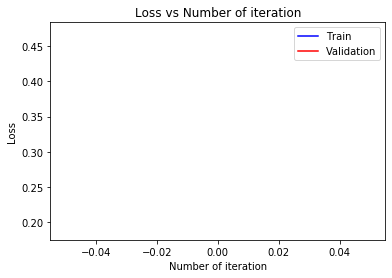

In [140]:
# visualization loss 
plt.plot(range(n_epochs+n_epochs2),train_losses, color = "blue",label='Train')
plt.plot(range(n_epochs+n_epochs2),valid_losses, color = "red", label='Validation')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Loss vs Number of iteration")
plt.legend()
plt.show()

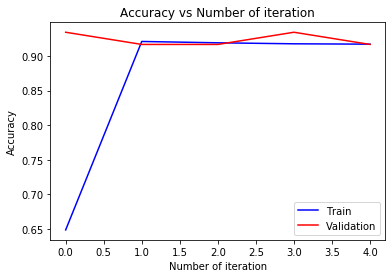

In [83]:
# visualization of accuracy
plt.plot(range(n_epochs+n_epochs2),train_accuracy, color = "blue",label='Train')
plt.plot(range(n_epochs+n_epochs2),valid_accuracy, color = "red", label='Validation')
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iteration")
plt.legend()
plt.show()

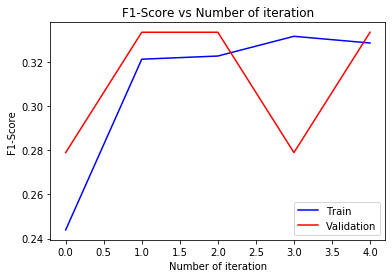

In [84]:
# visualization of f1-score
plt.plot(range(n_epochs+n_epochs2),train_f1_scores,color = "blue",label='Train')
plt.plot(range(n_epochs+n_epochs2),valid_f1_scores,color = "red", label='Validation')
plt.xlabel("Number of iteration")
plt.ylabel("F1-Score")
plt.title("F1-Score vs Number of iteration")
plt.legend()
plt.show()

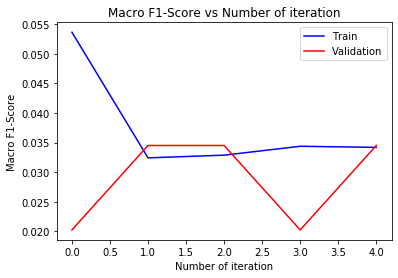

In [85]:
# visualization of macro f1-score
plt.plot(range(n_epochs+n_epochs2),train_macrof1_scores,color = "blue",label='Train')
plt.plot(range(n_epochs+n_epochs2),valid_macrof1_scores,color = "red", label='Validation')
plt.xlabel("Number of iteration")
plt.ylabel("Macro F1-Score")
plt.title("Macro F1-Score vs Number of iteration")
plt.legend()
plt.show()

In [18]:
#mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
    image = image.clone().detach()
    image=image*255
    image=transforms.ToPILImage()(image)
    #image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
    #image = image.permute(1,2,0) 
    #image = torch.clamp(image,0,1)
    image = transforms.Resize(512)(image)
    return image

def visualize(image, actual , pred):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(denormalize(image))
    ax.grid(False)    
    classes=np.where(actual == 1)[0]
    for i , s in enumerate(classes):
        ax.text(0 , i*20  , s , verticalalignment='top', color="blue", fontsize=12, weight='bold')
 
    classes=np.where(pred == 1)[0]
    for i , s in enumerate(classes):
        ax.text(485 , i*20  , s , verticalalignment='top', color="red", fontsize=12, weight='bold')

    plt.show()

#visualize(image[0] , label[0].tolist() , output[0].tolist())


torch.Size([32, 4, 128, 128]) torch.Size([32, 28])


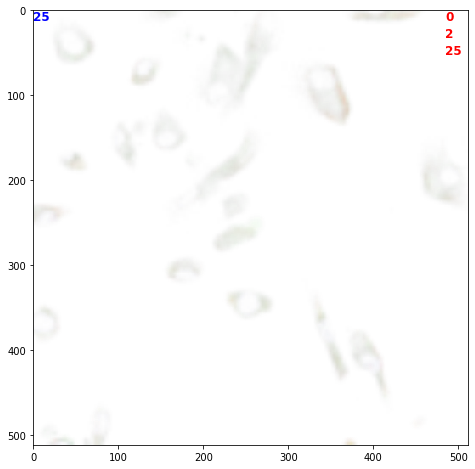

In [45]:
# Visualize results
dataiter=next(iter(validation_loader))
image = dataiter['image']
label = dataiter['label']
print(image.shape, label.shape)

checkpoint=torch.load('./saved_models/run.pt')
model = MultiClassifier()
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#model = MultiClassifier()
#model_path='./saved_models/run'+str(run_index)
#model.load_state_dict(torch.load(model_path))
model=model.eval()
output = model(image)
output = output>prob_threshold
image_id=0
visualize(image[image_id], label[image_id], output[image_id])
#output=output.detach().numpy()
#preds = np.where(out == 1)[1]

In [173]:
# Prediction
submission_filename='submission_v2.csv'
submission=pd.read_csv(folderpath+submission_filename)
submission.drop(['Predicted'], axis=1, inplace=True)
submission.head()

,Id,Cls0,Cls1,Cls2,Cls3,Cls4,Cls5,Cls6,Cls7,Cls8,...,Cls18,Cls19,Cls20,Cls21,Cls22,Cls23,Cls24,Cls25,Cls26,Cls27
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
def predict(model, submission_df, batch_size=16):
    test_dataset=ImgDataset(submission_df,
                           root_dir=folderpath+'updated_test/',transform=transformer)
    test_loader=torch.torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,num_workers=0)    

    for i, data in enumerate(test_loader):
        #dataiter = next(iter(test_loader))
        #image = dataiter['image']
        image=data['image']
        print(image.shape)
        out = model(image)
        out=out>prob_threshold        
        label=out.to(torch.int).detach().numpy()
        print(label.shape)
        submission_df.iloc[i:batch_size,1:]=label
    return submission_df

# Prediction
pred_start_index=0
pred_len=16
#out_trainfile=folderpath+'submission_v3.csv'
#submission=pd.read_csv(out_trainfile)
submission_data=submission.iloc[pred_start_index:pred_len]
submission_data.head()

checkpoint=torch.load('./saved_models/run.pt')
model = MultiClassifier()
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model=model.eval()

#model_path='./saved_models/run'+str(run_index)
#model=torch.load(model_path)
#model=model.eval()
final_submission=predict(model, submission_data,batch_size)
final_submission.head(batch_size)

torch.Size([16, 4, 128, 128])
(16, 28)


,Id,Cls0,Cls1,Cls2,Cls3,Cls4,Cls5,Cls6,Cls7,Cls8,...,Cls18,Cls19,Cls20,Cls21,Cls22,Cls23,Cls24,Cls25,Cls26,Cls27
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,1
